# AIML231 Assignment 3 | Part Three
> Shemaiah Rangitaawa `300601546`

# Part Three | Neural Networks

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print('Device:', device)
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)
    print('Total Memory (GB):', torch.cuda.get_device_properties(
        0).total_memory / 1e9)  # Convert bytes to GB
    print('Number of GPUs:', torch.cuda.device_count())
else:
    print('CUDA is not available')

Device: cuda
GPU: NVIDIA GeForce RTX 2070
CUDA version: 12.1
Total Memory (GB): 8.589606912
Number of GPUs: 1


In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# Load and split the dataset
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=231)

# Normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Network Definition

In [3]:
import torch
import torch.nn as nn


class MLPNN(nn.Module):
    def __init__(self, input_size=64, num_classes=10, layers=[256], activation_func=nn.ReLU()):
        super(MLPNN, self).__init__()
        self.layers = nn.ModuleList()

        # Create layers based on the layers list
        layer_sizes = [input_size] + layers
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

        # Output layerF
        self.layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.activation = activation_func

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        # No activation here as it will be included in CrossEntropyLoss
        x = self.layers[-1](x)
        return x

## Training

In [4]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=15, print_stats=False):
    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Iterate over data
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.float() / total_samples

        # Append loss and accuracy to lists
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        if print_stats:
            print(
                f'Epoch {epoch+1}: Loss = {epoch_loss:.3f}, Accuracy = {epoch_acc:.0%}')

    return losses, accuracies

In [5]:
model = MLPNN(activation_func=nn.ReLU())  # ReLU activation
criterion = nn.CrossEntropyLoss()  # Cross entropy loss
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001)  # Using Adam optimizer
relu_loss, relu_acc = train_model(
    model, train_loader, criterion, optimizer, num_epochs=15, print_stats=True)

Epoch 1: Loss = 2.101, Accuracy = 54%
Epoch 2: Loss = 1.570, Accuracy = 86%
Epoch 3: Loss = 1.020, Accuracy = 89%
Epoch 4: Loss = 0.651, Accuracy = 91%
Epoch 5: Loss = 0.458, Accuracy = 92%
Epoch 6: Loss = 0.356, Accuracy = 93%
Epoch 7: Loss = 0.288, Accuracy = 95%
Epoch 8: Loss = 0.244, Accuracy = 96%
Epoch 9: Loss = 0.215, Accuracy = 96%
Epoch 10: Loss = 0.190, Accuracy = 96%
Epoch 11: Loss = 0.170, Accuracy = 97%
Epoch 12: Loss = 0.156, Accuracy = 97%
Epoch 13: Loss = 0.140, Accuracy = 98%
Epoch 14: Loss = 0.129, Accuracy = 98%
Epoch 15: Loss = 0.123, Accuracy = 98%


## Test set evaluation

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def evaluate_model(model, test_loader):
    model.eval()
    total_accuracy = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            total_accuracy += accuracy(outputs, labels)

    # Average the accuracy across all batches
    test_accuracy = total_accuracy / len(test_loader)
    print(f"Test Accuracy: {test_accuracy:.2%}")
    return test_accuracy


relu_test_acc = evaluate_model(model, test_loader)

Test Accuracy: 95.83%


## Five Example Predictions

Test Image 0: Predicted Label: 4, Actual Label: 4
Test Image 1: Predicted Label: 5, Actual Label: 5
Test Image 2: Predicted Label: 1, Actual Label: 1
Test Image 3: Predicted Label: 4, Actual Label: 4
Test Image 4: Predicted Label: 1, Actual Label: 1


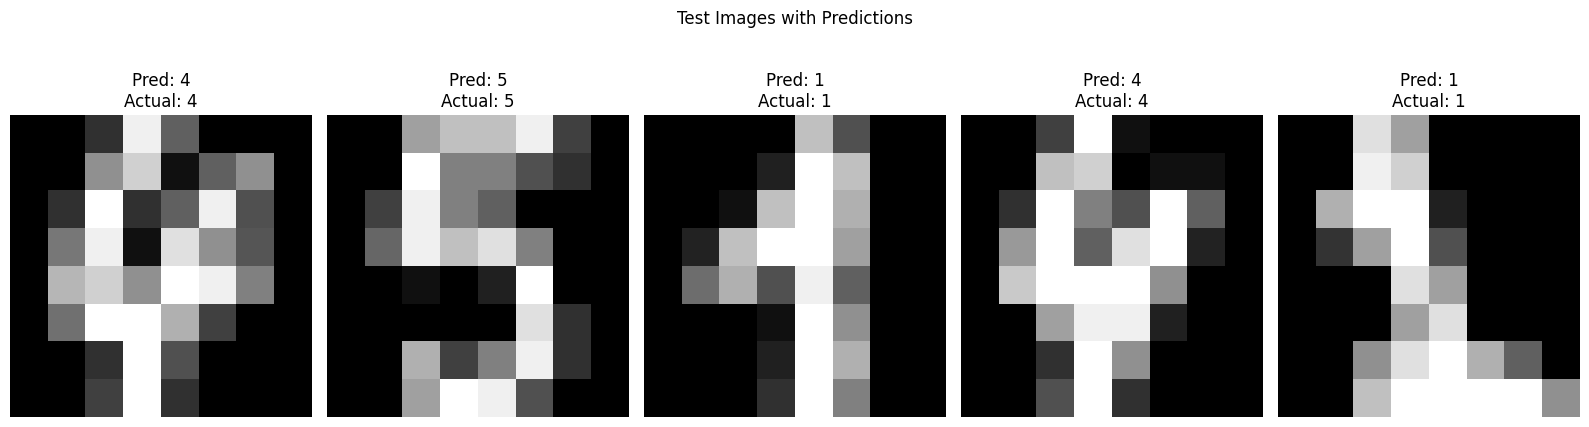

In [7]:
import matplotlib.pyplot as plt
import torch

model.eval()

test_predictions = []
with torch.no_grad():
    for i in range(5):  # 5 images
        img, label = test_dataset[i]
        if img.dim() == 1:
            img = img.view(8, 8)

        img_flat = img.view(-1)
        output = model(img_flat.unsqueeze(0))
        pred = output.argmax(dim=1).item()
        test_predictions.append((img, pred, label))

fig, axes = plt.subplots(1, 5, figsize=(16, 5))
fig.suptitle('Test Images with Predictions')

for i, (img, pred, label) in enumerate(test_predictions):
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f"Pred: {pred}\nActual: {label}")
    print(f"Test Image {i}: Predicted Label: {pred}, Actual Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Experimentation with Different Activation Functions

In [8]:
# Mapping of model configurations
activations = {
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid(),
    "ReLU": nn.ReLU(),
    "Hardshrink": nn.Hardshrink(),
}

# Color mapping for each activation function (for plotting later)
color_map = {
    "Tanh": "rgba(255, 99, 132, 0.6)",
    "Sigmoid": "rgba(54, 162, 235, 0.6)",
    "ReLU": "rgba(255, 206, 86, 0.6)",
    "Hardshrink": "rgba(75, 192, 192, 0.6)",
}

# Dictionary to store results
results = {}

# Loop through each activation function, train and evaluate the model
for name, func in activations.items():
    print(f"Training with {name} activation...")
    model = MLPNN(activation_func=func)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses, accuracies = train_model(model, train_loader, criterion, optimizer)
    evaluate_model(model, test_loader)  # Print test accuracy
    print()

    # Store results
    results[name] = {
        "losses": losses,
        "accuracies": accuracies
    }

Training with Tanh activation...
Test Accuracy: 95.57%

Training with Sigmoid activation...
Test Accuracy: 91.25%

Training with ReLU activation...
Test Accuracy: 95.05%

Training with Hardshrink activation...
Test Accuracy: 94.37%



> Plotting function definition

In [9]:
import plotly.graph_objects as go


def plot_training_results(results, colors):
    if not results:
        print("No results to display.")
        return

    # Determine the number of epochs from the first entry in the results
    epochs = list(range(1, len(next(iter(results.values()))['losses']) + 1))

    # Create figures for loss and accuracy
    fig = go.Figure()

    # Adding Loss and Accuracy Traces
    for name, data in results.items():
        fig.add_trace(go.Scatter(
            x=epochs, y=data['losses'],
            mode='lines+markers',
            name=name,
            line=dict(color=colors[name]),
            legendgroup=name,  # Group by name for single legend entry
            showlegend=True
        ))
        fig.add_trace(go.Scatter(
            x=epochs, y=data['accuracies'],
            mode='lines+markers',
            name=name,
            line=dict(color=colors[name]),
            xaxis='x2',
            yaxis='y2',
            legendgroup=name,  # Group by name for single legend entry
            showlegend=False  # Hide legend for accuracy to avoid duplicate entries
        ))

    # Update layout for a subplot appearance with legend on the right
    fig.update_layout(
        title='Training Results: Loss and Accuracy',
        xaxis=dict(title='Epoch', domain=[0, 0.45]),
        yaxis=dict(title='Loss'),
        xaxis2=dict(title='Epoch', domain=[0.55, 1]),
        yaxis2=dict(title='Accuracy (%)', anchor='x2'),
        legend=dict(
            x=1.05,
            xanchor='left',
            y=0.5,
            yanchor='middle'
        ),
        height=700
    )

    return fig


plot_training_results(results, color_map).show()

## Experimentation with Hidden Layers and Neurons

In [10]:
def network_configurations(input_size, num_classes, configurations, train_loader, test_loader):
    results = {}
    for config in configurations:
        print(f"\nTraining model with layers: {config}")
        model = MLPNN(input_size=input_size,
                      num_classes=num_classes, layers=config)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        losses, accuracies = train_model(
            model, train_loader, criterion, optimizer)
        evaluate_model(model, test_loader)
        results[f"Layers {len(config)} Neurons {config}"] = {
            'losses': losses,
            'accuracies': accuracies
        }

    return results


# Different configurations
configurations = [
    [256],  # 1 hidden layer with 256 neurons
    [256, 256],  # 2 hidden layers with 256 neurons each
    [512],  # 1 hidden layer with 512 neurons
    [128, 256, 128],    # 3 hidden layers with varying neurons
    [128, 256, 256, 128],   # 4 hidden layers with varying neurons
]

nl_color_map = {
    "Layers 1 Neurons [256]": "rgba(255, 99, 132, 0.6)",
    "Layers 2 Neurons [256, 256]": "rgba(54, 162, 235, 0.6)",
    "Layers 1 Neurons [512]": "rgba(255, 206, 86, 0.6)",
    "Layers 3 Neurons [128, 256, 128]": "rgba(153, 102, 255, 0.6)",
    "Layers 4 Neurons [128, 256, 256, 128]": "rgba(75, 192, 192, 0.6)",
}

# nl, short for Neurons & Layers
nl_results = network_configurations(
    input_size=64,
    num_classes=10,
    configurations=configurations,
    train_loader=train_loader,
    test_loader=test_loader
)


Training model with layers: [256]
Test Accuracy: 95.57%

Training model with layers: [256, 256]
Test Accuracy: 95.94%

Training model with layers: [512]
Test Accuracy: 95.05%

Training model with layers: [128, 256, 128]
Test Accuracy: 94.64%

Training model with layers: [128, 256, 256, 128]
Test Accuracy: 94.64%


In [11]:
plot_training_results(nl_results, nl_color_map)